<center>
<img src="http://image.yes24.com/goods/87039632/800x0" width="200" height="200"><br>
</center>


 - Github: [yoonkt200](https://github.com/yoonkt200/python-data-analysis)

# Chapter 03 미래를 예측하는 데이터 분석

#### 이 장의 핵심 개념
- 지도 학습과 비지도 학습의 개념을 이해한다.
- 회귀 분석으로 예측을 수행한다.
- 시계열 데이터의 트렌드를 예측한다.
- 수학적 기법을 활용하여 평점을 예측한다.

### 3.3 미래에 볼 영화의 평점 예측하기

데이터 분석을 통해 아직 사람들이 보지 않았지만 좋아할 만한 영화들을 추천할 수 있을까요? 넷플릭스 같은 서비스들은 이러한 것들을 평점 예측 기법으로 제공하고 있다. 이번 절에서는 이러한 평점 예측 기법을 알아보겠다.

### Step1 탐색: MovieLens 데이터 살펴보기

MovieLens 데이터는 총 3개의 데이터셋으로 분리되어 있으며 데이터셋을 구성하는 피처는 아래와 같다. 각 데이터는 '::' 구분자로 열을 구분하였기 때문에 read_csv() 함수를 사용할 때 delimiter='::'파라미터를 포함해야 한다. 3개의 데이터(rating_data, movie_data, user_data)를 각각 head()함수로 살펴본 결과는 다음과 같다.
- MovieLens 데이터셋의 기본 정보 구하기

In [9]:
# -*- coding utf-8 -*-
%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Source : https://grouplens.org/datasets/movielens

rating_file_path = "./data/ml-1m/ratings.dat"
movie_file_path = "./data/ml-1m/movies.dat"
user_file_path = "./data/ml-1m/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path, 
                                     names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::')
movie_data = pd.io.parsers.read_csv(movie_file_path, 
                                    names=['movie_id', 'title', 'genre'], delimiter='::')
user_data = pd.io.parsers.read_csv(user_file_path, 
                                   names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::')

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [10]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### Step2 분석: 탐색적 데이터 분석하기

탐색적 데이터 분석을 통해 영화 데이터를 살펴보자. 다음의 실행 결과는 영화의 개수와 연도별 탐색에 대한 출력 결과이다. 영화의 개수는 약 4,000여 개 정도라는 것을 알 수 있고, 1990년대 후반부터 2000년대 초반의 영화가 가장 많은 것을 알 수 있다. 영화의 연도 정보는 movie_data['title'].apply(lambda x:x[-5:-1]) 코드를 통해 추출한 것으로 영화의 제목 뒤에 따라붙는 연도 정보를 이용한 것이다.
- 분석할 영화의 정보 탐색하기

In [13]:
# 총 영화의 개수를 출력한다.
print("total number of movie in data:",len(movie_data['movie_id'].unique()))

total number of movie in data: 3883


In [14]:
# 연도별 영화 개수가 많은 top10 연도를 출력한다.
movie_data['year'] = movie_data['title'].apply(lambda x:x[-5:-1])

In [15]:
movie_data['year'].value_counts().head(10)

1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


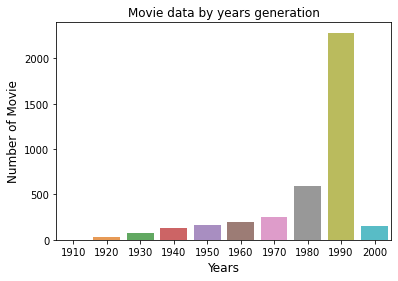

In [16]:
# 영화의 연대별 영화 수를 출력한다.

movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0")
moview_year_term = movie_data['year_term'].value_counts().sort_index()
           
           
sns.barplot(moview_year_term.index, moview_year_term.values, alpha = 0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movie', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

다음으로 영화 데이터에서 가장 많이 등장한 장르가 무엇인지를 탐색해 보자. movie_data의 피처인 genre는 '드라마'l'코미디'l'액션'l처럼 'l'이라는 구분자를 포함하여 여러 장르를 하나의 문자열에 포함하고 있다. 따라서 데이터 등장하는 모든 개별 장르를 세기 위해서는 split() 함수로 genre 데이터를 분리해야한다. 각 장르마다의 등장 개수는 dictionary 자료로 저장한다. 실행코드는 다음과 같다.
- 장르의 속성 탐색하기

In [17]:

# 가장 많이 등장한 장르의 속성을 추출한다. (예시 : Drama)
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    
    # genre 피처를 ‘|’ 구분자로 분리한다.
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장한다.
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1

print(unique_genre_dict)


{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


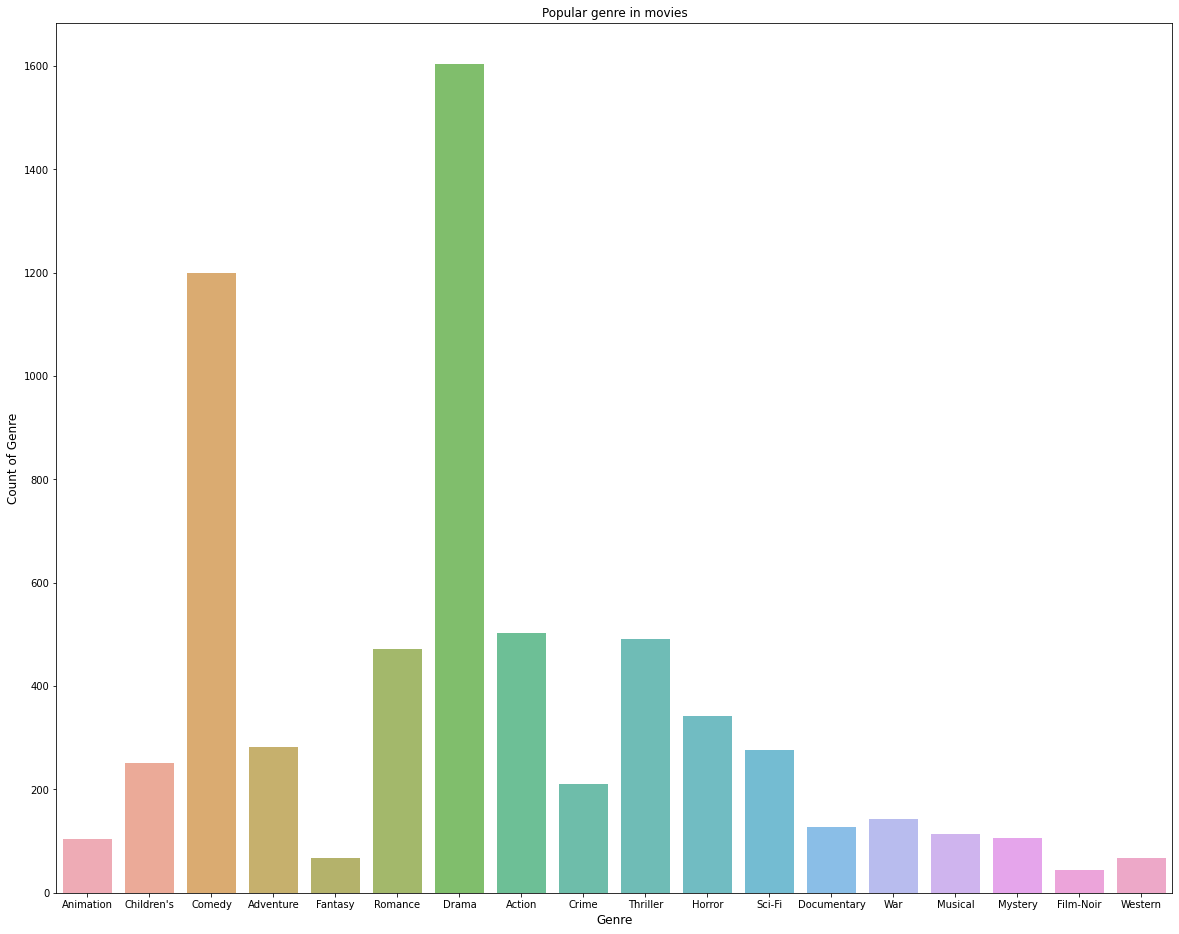

In [18]:
# unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력한다.
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

그리고 분석 대상이 되는 유저의 수를 탐색해보면 총 6,040 명으로 나타난다.
- 분석할 유저의 정보 탐색하기

In [19]:
# 유저의 수를 탐색 하자
print("total number of user in data:",len(user_data['user_id'].unique()))

total number of user in data: 6040


/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


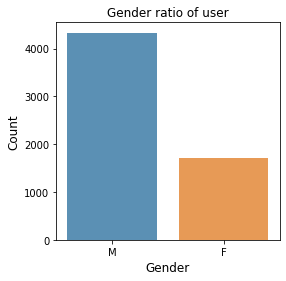

In [20]:
# 유저의 성별 탐색
plt.rcParams['figure.figsize']= [4,4]
user_gender = user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.8)


plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [21]:
# 유저의 연령대를 탐색합니다.
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


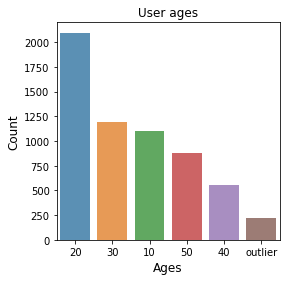

In [22]:
# 유저의 연령대 탐색하기
def age_classification(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"
    
user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts()

sns.barplot(user_ages.index, user_ages.values, alpha=0.8)

plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()
    


지금까지 user_data, movie_data 데이터의 특징을 살펴본 것은 '평점 예측'의 측면에서는 중요한 탐색이라고 볼 수 없었다. 하지만 rating 데이터는 평점 예측 데이터 분석에 중요한 데이터이기 때문에 조금 더 자세히 탐색을 수행해야 한다. 아래의 코드는 각 영화가 얼마나 많은 평가를 받았는지를 탐색한다. 실행 결과 그래프는 'movie_id'를 기준으로 groupby() 한뒤, 'rating'에 count() 함수를 적용한 결과이다. x축은 각 영화가 평가받은 횟수, y축은 각 영화가 평가 받은 횟수를 의미한다. 이를 통해 약 3800여 개의 영화 중 100개 미만의 평가를 받은 영화가 1,700여 개나 된다는 것을 알 수 있다. 이러한 영화들을 대상으로 한 '예상 평점'분석은 관람객에게 큰 의미가 있을 것이다.
- 평점 데이터의 정보 탐색하기

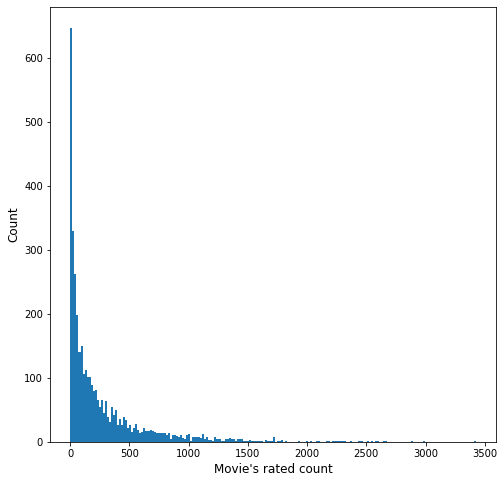

In [23]:
# 각 영화가 평가 받은 횟수를 탐색한다.

movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8,8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [24]:
print("total number of movie in data:",len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data: 3883
total number of movie rated below 100 : 1687


다음은 각 영화의 평균 평점을 알아보자. 아래의 코드에서는 agg() 함수로 각 영화당 rating의 개수와 평균값을 계산한다. 평균값에 대한 시각화는 실행 결과와 같다. 대부분의 평점은 2점~4점 사이로 나타났으며, 이를 통해 대부분의 영화 평점은 2점~4점 사이의 값으로 예측될 것이라는 가설을 수립할 수 있다.

In [25]:
# 영화별 평균 평점을 탐색해보자
movie_grouped_rating_info = rating_data.groupby("movie_id")['rating'].agg(['count','mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

In [26]:
movie_grouped_rating_info.head(5)

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


<AxesSubplot:>

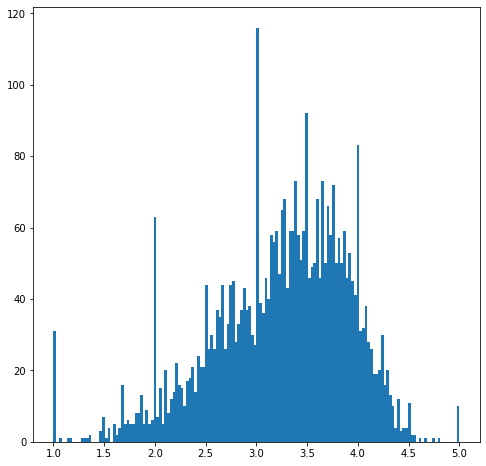

In [27]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

In [28]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력한다.
merged_data = movie_grouped_rating_info.merge(movie_data, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)


- `동일한 방식으로, 유저 그룹 단위의 평점 속성을 분석 하기'
    - 유저별로 평가한 영화 개수
    - 유저별로 평가한 평균 영화 점수
    - 유저별로 평가한 영화 점수의 편차

In [29]:
# 유저별 영화 평가를 탐색한다.
user_grouped_rating_info = rating_data.groupby('user_id')['rating'].agg(['count','mean', 'std'])
user_grouped_rating_info.columns = ['rated_count', 'rating_mean', 'rating_std']

In [30]:
user_grouped_rating_info.head()

,rated_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699


<AxesSubplot:>

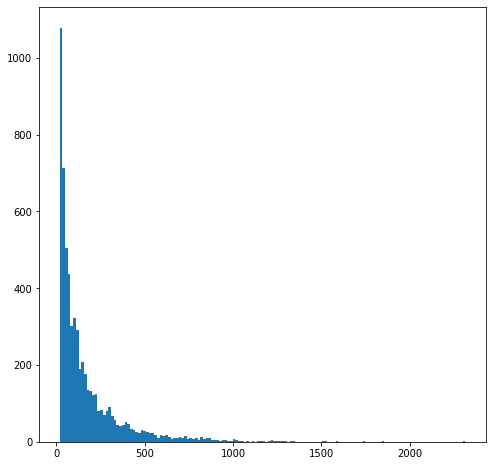

In [31]:
# 유저별로 평가한 영화 개수의 분포를 출력한다
user_grouped_rating_info['rated_count'].hist(bins=150, grid=False)

<AxesSubplot:>

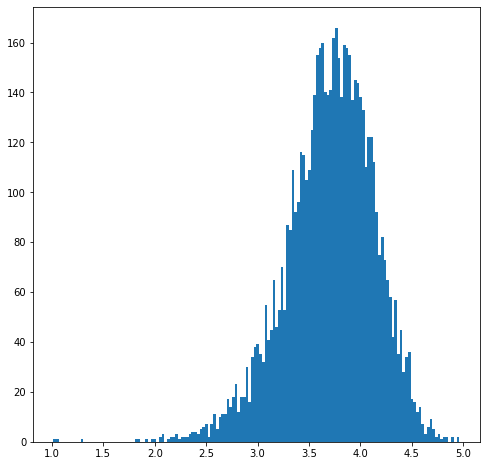

In [32]:
# 유저별로 평가한 영화 점수 평균의 분포를 그래프로 출력한다.
user_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

<AxesSubplot:>

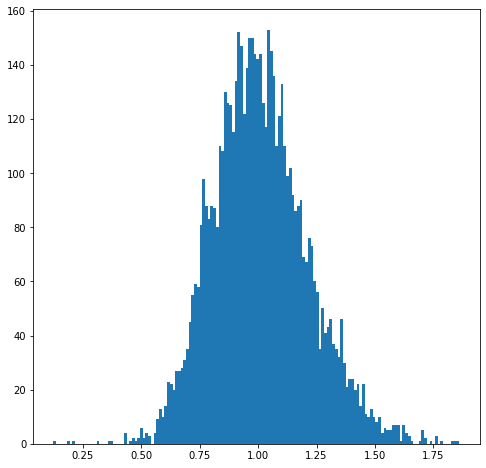

In [33]:
# 유저별로 평가한 영화 점수 편차의 분포를 그래프로 출력한다.
user_grouped_rating_info['rating_std'].hist(bins=150, grid=False)

이제 이번 절의 진짜 목적인 영화 평점 예측을 수행해보자. 현재 분석 중인 MovieLens 데이터는 U I R (user item rating) 데이터셋 이다. 이러한 데이터는 행렬로 나타내기에 매우 용이하며, 다음의 실행 결과처럼 시각화할 수 있다. 행렬 그래프의 행과 열은 각각 user와 movie를 의미하며 점을 표현하는 컬러는 Rating 값을 의미한다.
- user-movie 형태의 표로 살펴보기

In [34]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [35]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성한다.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(['user_id','movie_id']).unstack()

In [36]:
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

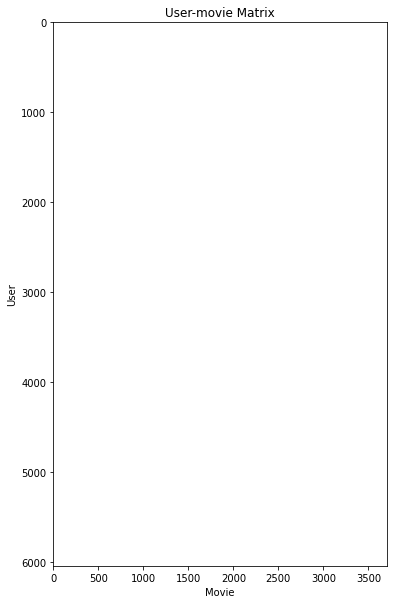

In [37]:
# user- movie 표를 시각화 한다
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

### Step 3 예측: 수학적 기법을 활용해 평점 예측하기

행렬 완성은 '행렬 분해' 방법을 이용합니다. 우선 SVD를 사용하기 위해 surprise 라이브러리를 설치한다.

In [38]:
#!pip3 install surprise

##### 빈칸을 포함한 user-item 행렬 생성

In [39]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

np.set_printoptions(suppress=True)

reader = Reader(rating_scale=(1, 5))

In [40]:
# 데이터 프레임을 생성합니다.
ratings_dict = {'item_id': [1,2,3,1,2,3,2],
                'user_id': ['a','a','a','b','b','b','c'],
                'rating': [2,4,4,2,5,4,5]}
df = pd.DataFrame(ratings_dict)
df.head(10)

,item_id,user_id,rating
0,1,a,2
1,2,a,4
2,3,a,4
3,1,b,2
4,2,b,5
5,3,b,4
6,2,c,5


In [41]:
# 데이터 프레임을 행렬로 변환하여 확인합니다.
df_matrix_table = df[['user_id', 'item_id', 'rating']].set_index(["user_id", "item_id"]).unstack().fillna(0)
df_matrix_table.head(10)

rating          
item_id      1    2    3
user_id                 
a          2.0  4.0  4.0
b          2.0  5.0  4.0
c          0.0  5.0  0.0

라이브러리 사용법은 아래의 코드와 같다. 먼저 평점의 범위가 1~5인 Reader 객체를 생성한다. 그리고 load_from_df() 함수와 build_full_transer() 함수를 이용하여 rating 데이터를 surprise 라이브러리의 데이터셋 형태로 변환해 준다. 마지막으로 SVD라는 클래스를 선안한 뒤, model.fit(train_data)로 행렬 완성 모델을 학습한다. 일반적인 성능의 컴퓨터에서는 약 1분에서 5분 사이의 시간이 소요된다.
###  MovieLens 데이터에 SVD 적용하기
- SVD를 이용한 빈칸 채우기 학습

In [42]:
# SVD 사용을 위한 데이터셋을 생성합니다.
data = Dataset.load_from_df(df=df[["user_id", "item_id", "rating"]], reader=reader)
train_data = data.build_full_trainset()

In [43]:
# SVD 모델을 학습합니다.
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=10)
model.fit(train_data)

In [ ]:
# 학습한 모델을 기반으로 빈공간의 점수를 예측합니다.

"""
build_anti_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""

# test_data : 학습에 사용된 유저, 혹은 아이템이지만 점수는 매겨지지 않은 데이터입니다.
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 아래의 결과는 빈공간(test_data)의 점수를 예측한 결과입니다.
for _, iid, _, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "predicted rating :", predicted_rating)

In [ ]:
"""
build_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""
test_data = train_data.build_testset()
predictions = model.test(test_data)

# 원래부터 비어있지 않았던 행렬의 값들을 출력한 것입니다. real rating은 원래 값, predicted rating은 행렬 완성 후 예측된 값입니다.
for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

### [아직 평가하지 않은 영화의 점수 예측하기]
##### MovieLens 데이터에 SVD 적용하기

In [ ]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

다음으로 학습한 모델의 평점 예측 결과를 살펴보기 위해 한 명의 데이터를 선정 한다. 예제에서는 user_id가 4인 유저를 선정했다.
- 영화의 점수를 예측할 타겟 유저 선정하기

In [ ]:
# 